# Bankruptcy Challenge - La Redoute

### Main ideas :
###     - Scaling only on 2012
###     - Bagging and subsample 2011 (picking only 1000 samples of 2011 and the 400 of 2012)
###     - XGBoost + RandomizedSearchCV for our 5 models (not only one set of parameters)
###     - Features selections

NB : Here RandomizedSearchCV was reduced to save time. However to achieve a good score more iterations are needed. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import fancyimpute as fi
import DataManipulation as dm
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel 
from sklearn.cross_validation import cross_val_score
from itertools import cycle
from scipy import interp

Using TensorFlow backend.
/home/ldarmet/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Loading data

In [2]:
datapath = 'X_train.txt'
ypath = 'y_train.txt'
testpath = 'X_test.txt'
headerpath = 'header.csv'

# Using DataManipulation.py to read the .txt
data = dm.Data(trainpath=datapath,testpath=testpath,targetpath=ypath,headerpath=headerpath) 
train = data.getTrain()
nbtrain = train.shape[0]
target = data.getTarget()
test = data.getTest()
traintest = pd.concat([train,test])
traintest.iloc[:,-1] = traintest.iloc[:,-1].apply(lambda x: x-2011) # Year encoding

## Filling missing values

In [3]:
method = fi.SimpleFill(fill_method='median')
traintest = pd.DataFrame(data=method.complete(traintest.values),columns=train.columns)

We used median filling $\rightarrow$ very basic but KNN and SVD Iterative had poorer results in CV.

## Scaling

In [4]:
%%time
## Normalisation of 2012 only

mean_traintest = traintest.loc[traintest['year of measurement']==1].mean(axis=0)
std_traintest = traintest.loc[traintest['year of measurement']==1].std(axis=0)

for i,c in enumerate(traintest.columns.tolist()[:-1]): # on ne normalise pas l'année
    traintest.loc[traintest['year of measurement']==1,c] = traintest.loc[traintest['year of measurement']==1,c].apply(lambda x: (x-mean_traintest[i])/std_traintest[i])

## Rebuilding datasets

train = traintest.iloc[:nbtrain,:]
test = traintest.iloc[nbtrain:,:]

CPU times: user 1.35 s, sys: 8 ms, total: 1.36 s
Wall time: 1.35 s


## Features selection

In [5]:
%%time
model = xgb.XGBClassifier()
model.fit(train.values,target)

thresholds = np.sort(model.feature_importances_)
results = np.zeros((len(thresholds),3))
i=0
target = target.values.T.tolist()[0]
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(train)
    from sklearn.feature_selection import SelectFromModel
    # train model
    selection_model = xgb.XGBClassifier()
    scores = cross_val_score(selection_model, select_X_train, target, cv=10, scoring='accuracy',n_jobs=1,verbose=0)

    results[i,0]= np.mean(scores)
    results[i,1] = np.std(scores)
    results[i,2]=thresh
    i=i+1
    if i % 10 == 0:
        print 'Iteration',i,'on', len(thresholds)
    
best_tresh = results[np.min(np.where(results[:,0] == np.max(results[:,0]))),2]
print 'Best threshold :' ,best_tresh
print 'Number of discarded features:', np.min(np.where(results[:,0] == np.max(results[:,0]))), ',on 51.'
selection = SelectFromModel(model, threshold=best_tresh, prefit=False)
selection.fit(train, target)
select_X_train = selection.transform(train)
select_X_test = selection.transform(test)

/home/ldarmet/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ldarmet/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 10 on 51
Iteration 20 on 51
Iteration 30 on 51
Iteration 40 on 51
Iteration 50 on 51
Best threshold : 0.0157068055123
Number of discarded features: 30 ,on 51.
CPU times: user 4min 16s, sys: 360 ms, total: 4min 16s
Wall time: 1min 10s


Backward selection of features. XGBoost is used to return importance features (weight criterion, see doc).

### Display features importance and names

,0
0,Current Assets/Current Liabilities
1,(Cash+Mark.Sec)/Total Sales
2,Current Liabilities/Total Assets
3,Financial Expenses/Total Assets
4,(Cash+Mark.Sec)/Current Liabilities
5,Current Liabilities/Total Sales
6,Cash/Current Assets
7,Quick Assets/Total Assets
8,Shareholder Funds/Permanent Equity
9,Financial Expenses/Net Income


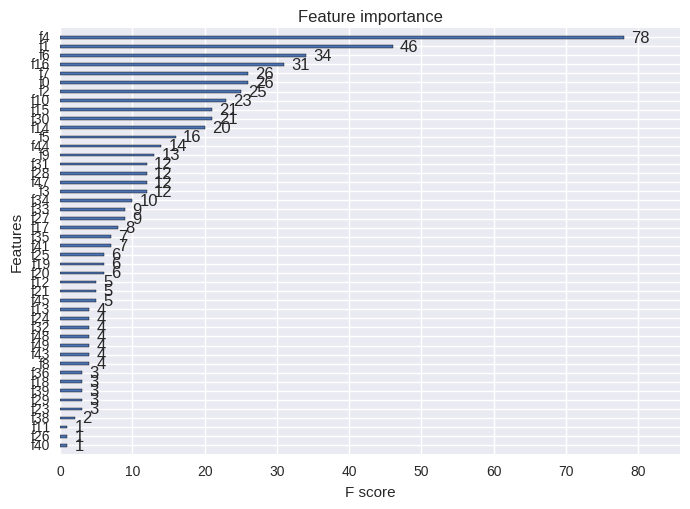

In [6]:
model = xgb.XGBClassifier()
model.fit(train.values,target)

xgb.plot_importance(model,height=0.3)
imp_feat = pd.DataFrame(train.columns[np.argsort(model.feature_importances_)[::-1]])
imp_feat

## Save results

In [7]:
train_save = pd.DataFrame(select_X_train,copy=True)
target_save = pd.DataFrame(target,columns=['t'],copy=True)
test_save = pd.DataFrame(select_X_test,copy=True)
train_year = pd.DataFrame(train['year of measurement'])

## Cross-validation (score estimation)

In [8]:
L_classifs = []

# RandomizedSearchCV distributions
param_distributions={'max_depth': sp.stats.randint(2,7),
                     'n_estimators' :sp.stats.randint(150,300),
                     'subsample': sp.stats.uniform(0.85,0.15),
                     'colsample_bytree': sp.stats.uniform(0.85,0.15)
}

# To plot ROC curves
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2
i = 0

# Data preparation
train = pd.DataFrame(select_X_train,copy=True)
label = pd.DataFrame(target,columns=['t'],copy=True)
test = pd.DataFrame(select_X_test,copy=True)

## Here we drop 1000 observations from 2011 to have a more balanced dataset
l_choice = np.random.choice(train.loc[data.getTrain()['year of measurement'] == 2011].index,size=1000,replace=False)
train = train.drop(l_choice)
label = label.drop(l_choice)

# Stratified Spilt on 10 folds
sss= StratifiedShuffleSplit(label,test_size=0.1,random_state=1)

acc = []

### Cross val loop

/usr/lib/python2.7/dist-packages/pandas/core/indexing.py:508: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Normalization done!
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.4min finished


acc on test set : 0.95, taille test set :  140 , nb2012 in test set : 0.0
Percentage of 2012 in the bad predictions 0.511627906977
------------------------------------------------------------------------------
Normalization done!
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.5min finished


acc on test set : 0.964285714286, taille test set :  140 , nb2012 in test set : 0.0
Percentage of 2012 in the bad predictions 0.46
------------------------------------------------------------------------------
Normalization done!
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.5min finished


acc on test set : 0.95, taille test set :  140 , nb2012 in test set : 0.0
Percentage of 2012 in the bad predictions 0.487804878049
------------------------------------------------------------------------------
Normalization done!
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.7min finished


acc on test set : 1.0, taille test set :  140 , nb2012 in test set : 0.0
Percentage of 2012 in the bad predictions 0.54347826087
------------------------------------------------------------------------------
Normalization done!
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.8min finished


acc on test set : 0.928571428571, taille test set :  140 , nb2012 in test set : 0.0
Percentage of 2012 in the bad predictions 0.54
------------------------------------------------------------------------------
Normalization done!
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.8min finished


acc on test set : 0.964285714286, taille test set :  140 , nb2012 in test set : 0.0
Percentage of 2012 in the bad predictions 0.516129032258
------------------------------------------------------------------------------
Normalization done!
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.7min finished


acc on test set : 0.964285714286, taille test set :  140 , nb2012 in test set : 0.0
Percentage of 2012 in the bad predictions 0.475
------------------------------------------------------------------------------
Normalization done!
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.9min finished


acc on test set : 0.971428571429, taille test set :  140 , nb2012 in test set : 0.0
Percentage of 2012 in the bad predictions 0.472222222222
------------------------------------------------------------------------------
Normalization done!
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.1min finished


acc on test set : 0.985714285714, taille test set :  140 , nb2012 in test set : 0.0
Percentage of 2012 in the bad predictions 0.5625
------------------------------------------------------------------------------
Normalization done!
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.4min finished


acc on test set : 0.985714285714, taille test set :  140 , nb2012 in test set : 0.0
Percentage of 2012 in the bad predictions 0.45
------------------------------------------------------------------------------


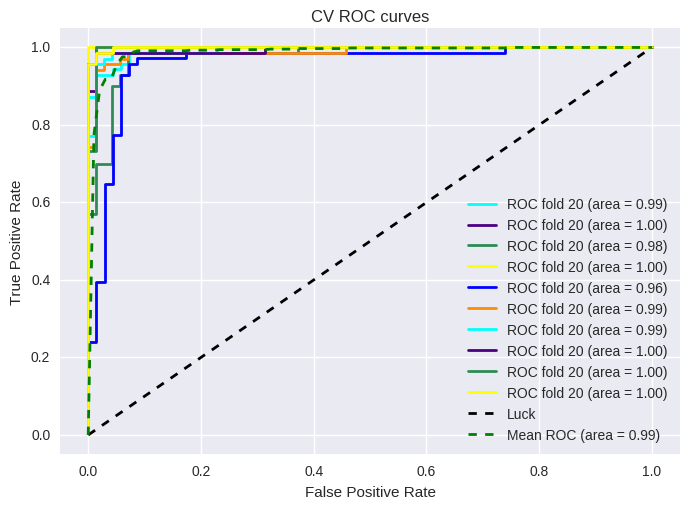

CPU times: user 1h 1min, sys: 44.5 s, total: 1h 1min 45s
Wall time: 18min 25s


In [9]:
%%time
i=0
for (idtrain, idtest),color in zip(sss,colors):
    dfXtrain = train.iloc[idtrain,:]
    ytrain = label.iloc[idtrain,:].values[:,0]
    dfXtest = train.iloc[idtest,:]
    superdf = pd.concat([dfXtest,train_year,label.iloc[idtest,:]],axis=1)
    
    # Dataset scaling
    mean_df = dfXtrain.mean(axis=0)
    std_df = dfXtrain.std(axis=0)

    for i,c in enumerate(dfXtrain.columns.tolist()): # RobustScaler or StandardScaler could be used here
        dfXtrain.loc[:,c] = dfXtrain.loc[:,c].apply(lambda x: (x-mean_df[i])/std_df[i])
        dfXtest.loc[:,c] = dfXtest.loc[:,c].apply(lambda x: (x-mean_df[i])/std_df[i])

    print "Normalization done!"
    Xtrain = dfXtrain.values
    Xtest = dfXtest.values

    clf = xgb.XGBClassifier(silent=False)
    estimator = RandomizedSearchCV(clf,param_distributions, n_iter=100,n_jobs=1,cv=5,scoring='accuracy',verbose=1)
    estimator.fit(Xtrain ,ytrain)
    preds = estimator.predict(Xtest) # Call predict with the best parameters 
    probas = estimator.predict_proba(Xtest)
    tempacc = accuracy_score(label.iloc[idtest,:],preds)
    acc.append(tempacc)

    print "acc on test set : " + str(tempacc) + ", taille test set : ",dfXtest.shape[0],", nb2012 in test set : " + str(np.sum(np.transpose(train_year.iloc[idtest,:].values)))

    print "Percentage of 2012 in the bad predictions " + str(superdf.loc[superdf.iloc[:,-2] == 1,:]['t'].mean())
    print'------------------------------------------------------------------------------'
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(label.iloc[idtest,:], probas[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= 10
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CV ROC curves')
plt.legend(loc="lower right")
plt.show()

(0.9664285714285713, 0.019704448891619614)


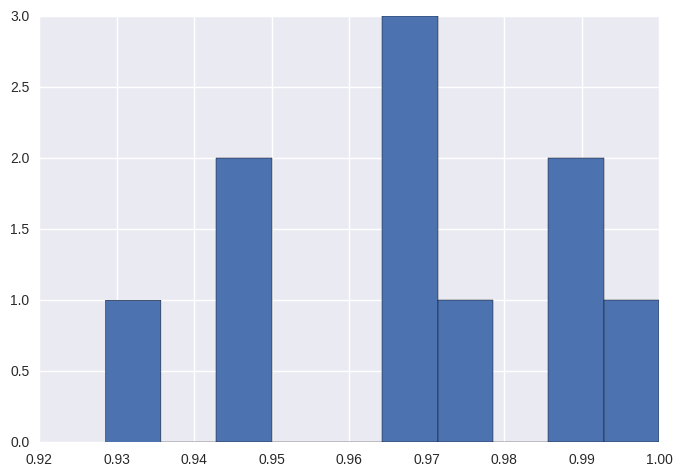

In [10]:
plt.hist(acc)
print(np.mean(acc), np.std(acc))

## Some overfitting here... During our sub we made more iteration fo RandomizedSearchCV but here to save time we have reduced it to 100 iterations.

### Confusion matrix for last fold

Confusion matrix, without normalization
[[68  1]
 [ 1 70]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.01  0.99]]


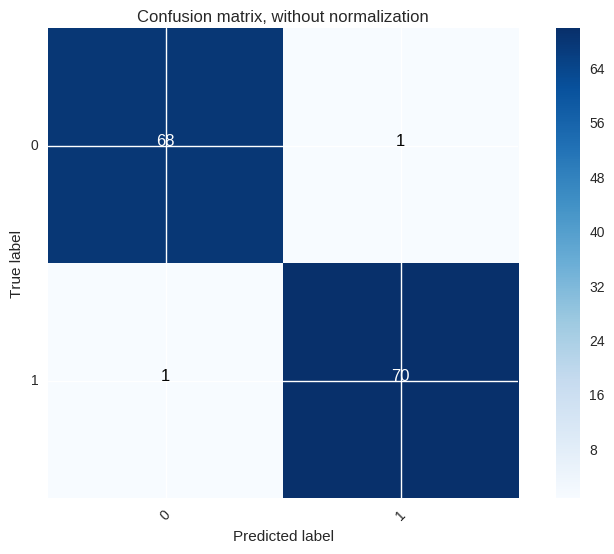

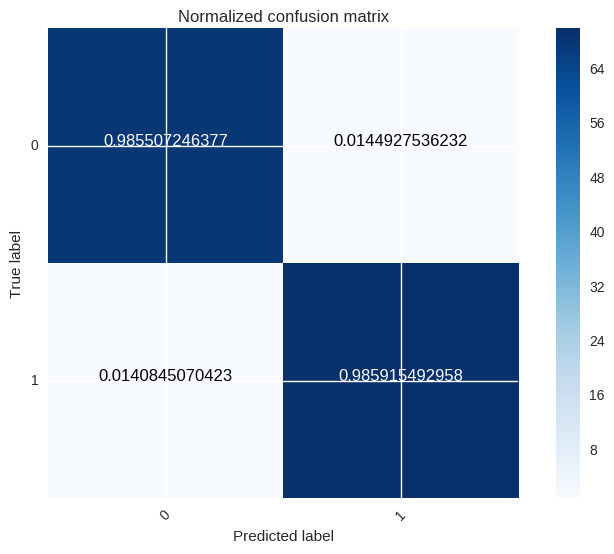

In [11]:
class_names = ['0','1']
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(label.iloc[idtest,:],preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Submit

The result of our a submit is a bagging of 5 boostrap samples (2012 samples are picked with proba 1). The data fusion has been done with a soft voting (on proba). It is possible here because XGBoost is well calibrated.

In [12]:
L_classifs = []

# RandomizedSearchCV distributions
param_distributions={'max_depth': sp.stats.randint(2,7),
                     'n_estimators' :sp.stats.randint(150,300),
                     'subsample': sp.stats.uniform(0.85,0.15),
                     'colsample_bytree': sp.stats.uniform(0.85,0.15)
}
preds_proba=0
for i in range(5):
    print 'Iteration',i+1,'on 5'
    train = pd.DataFrame(select_X_train,copy=True)
    label = pd.DataFrame(target,columns=['t'],copy=True)
    test = pd.DataFrame(select_X_test,copy=True)
    l_choice = np.random.choice(train.loc[data.getTrain()['year of measurement'] == 2011].index,size=1000,replace=False)
    train = train.drop(l_choice)
    label = label.drop(l_choice)
    
    mean_df = train_save.mean(axis=0)
    std_df = train_save.std(axis=0)

    for i,c in enumerate(train.columns.tolist()): # RobustScaler or StandardScaler could be used here
        train.iloc[:,i] = train.iloc[:,i].apply(lambda x: (x-mean_df[i])/std_df[i])
        test.iloc[:,i] = test.iloc[:,i].apply(lambda x: (x-mean_df[i])/std_df[i])

    Xtrain = train.values
    ytrain = label.values[:,0]
    Xtest = test.values
    
    mean_df = np.mean(Xtrain,axis=0)
    std_df = np.std(Xtrain,axis=0)

    clf1 = xgb.XGBClassifier()
    estimator = RandomizedSearchCV(clf1,param_distributions, n_iter=200,n_jobs=1,cv=5,scoring='accuracy',verbose=1)
    estimator.fit(Xtrain ,ytrain)
    L_classifs.append(estimator.best_estimator_)
    preds_proba = preds_proba + estimator.predict_proba(Xtest)
    predictions = estimator.predict(Xtest)
    print 'Best parameters found by grid search are :', estimator.best_params_
    print 'Best score found by grid search is :', estimator.best_score_
    del train
    del label
    del test
    print "Proportion of 1 in the predict: " + str(np.mean(predictions))
    print'----------------------------------------------------------------------------'

Iteration 1 on 5
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  3.9min finished


Best parameters found by grid search are : {'n_estimators': 286, 'subsample': 0.86953313641582264, 'colsample_bytree': 0.87834199093716092, 'max_depth': 4}
Best score found by grid search is : 0.959285714286
Proportion of 1 in the predict: 0.514053716427
----------------------------------------------------------------------------
Iteration 2 on 5
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.5min finished


Best parameters found by grid search are : {'n_estimators': 245, 'subsample': 0.98596881817623705, 'colsample_bytree': 0.86894464936269811, 'max_depth': 3}
Best score found by grid search is : 0.965714285714
Proportion of 1 in the predict: 0.509681449094
----------------------------------------------------------------------------
Iteration 3 on 5
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.5min finished


Best parameters found by grid search are : {'n_estimators': 243, 'subsample': 0.99172101454757611, 'colsample_bytree': 0.97661304892363399, 'max_depth': 6}
Best score found by grid search is : 0.962142857143
Proportion of 1 in the predict: 0.508432229856
----------------------------------------------------------------------------
Iteration 4 on 5
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.4min finished


Best parameters found by grid search are : {'n_estimators': 163, 'subsample': 0.89395587758404993, 'colsample_bytree': 0.91113493126962553, 'max_depth': 4}
Best score found by grid search is : 0.969285714286
Proportion of 1 in the predict: 0.510930668332
----------------------------------------------------------------------------
Iteration 5 on 5
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters found by grid search are : {'n_estimators': 288, 'subsample': 0.99171893499790076, 'colsample_bytree': 0.88637376879523377, 'max_depth': 3}
Best score found by grid search is : 0.958571428571
Proportion of 1 in the predict: 0.509056839475
----------------------------------------------------------------------------


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.4min finished


The proportion of 1 in the predict should be close to 0.5. Here it seems ok.

In [13]:
preds = np.int_(np.argmax(preds_proba,axis=1)) # soft voting
test_ids = np.arange(len(test_save)) 
submission = pd.DataFrame(preds)
submission.columns = ['Prediction']
submission.insert(0, 'Id', test_ids)
submission.reset_index()
submission.to_csv('for_the_lolz.csv', index = False)
submission.head()
submission['Prediction'].mean()

0.51155527795128042

Our parameters found by RandomSearch are probably not optmial because we have too much 1 (819/1600 our best sub had 813/1600). It should be re-run with more iterations.

Beside that, this is a better to have too much 1 (type 1 error).

# "Si tu veux t'assoir sur le trône faudra t'assoir sur mes genoux"